### Homework 1, Hitting a baseball

In [99]:
%matplotlib inline 

import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 
import scipy.optimize as op 
"""
I need to make this shit more general -- I need to incorporate t terms into f_prime to make 
more general. 
"""
def runge_kutta_step(f_prime, h, y_cur, *args): 
    """
    Here y_cur is the current value of y in the simulation.
    Assuming that f_prime has no direct dependence on t. 
    h is the step size in the simulation. 
    """
    k1 = f_prime(y_cur, *args) 
    k2 = f_prime(y_cur + (h/2.)*k1, *args) 
    k3 = f_prime(y_cur + (h/2.)*k2, *args) 
    k4 = f_prime(y_cur + h*k3, *args) 
    return y_cur + (h/6.)*(k1 + 2*k2+ 2*k3 + k4) 

def f_prime(y, v_wind):
    """
    v_wind is the x-component of a velocity vector. 
    """
    y_prime = np.zeros(4) #dealing with 2D problem here
    x, vx, y, vy = y 
    v = np.sqrt((vx-v_wind)**2 + vy**2) 
    vd = 35. #This is some constant. 
    delta = 5 #Another constant. 
    g = 9.8 # a constant 
    b2 = 0.0039 + (0.0058/(1. + np.exp((v - vd)/delta)))
    y_prime[0] = vx 
    y_prime[1] = -(b2*v*(vx-v_wind))
    y_prime[2] = vy 
    y_prime[3] = -(g + (b2*v*vy))
    return y_prime 

def f_prime3D(y, v_wind):
    """
    Here v_wind is a vector corresponding the direction of the wind:
    [v_wind_x, v_wind_y, v_wind_z] 
    normally the z component will be zero. 
    """
    y_prime = np.zeros(6) #dealing with 3D problem here
    x, vx, y, vy, z, vz = y 
    v = np.sqrt((vx-v_wind[0])**2 + (vy-v_wind[1])**2 + (vz-v_wind[2])**2) 
    vd = 35. #This is some constant. 
    delta = 5 #Another constant. 
    g = 9.81 # a constant. the gravitational one. 
    b2 = 0.0039 + (0.0058/(1. + np.exp((v - vd)/delta)))
    y_prime[0] = vx 
    y_prime[1] = -(b2*v*(vx-v_wind[0]))
    y_prime[2] = vy
    y_prime[3] = -(b2*v*(vy-v_wind[1]))
    y_prime[4] = vz 
    y_prime[5] = -(g + (b2*v*(vz-v_wind[2])))
    
    return y_prime 

def run_simulation(theta, h,mode,*args): #v_init=110., h_init=4.5, v_wind=0.0):
    """
    Assumes that you give the starting velocity and height of player in 
    imperial (ick) units
    """ 
    #keeping args if statements inside mode blocks incase I need to make more drastic changes later. 
    if (mode == '2d'):
                   
        if len(args) == 0:
            v_init, h_init, v_wind = 110, 4.5, 0.0 
        elif len(args) == 3:
            v_init, h_init, v_wind = args 
        elif len(args) == 1:
            v_init, h_init = 110, 4.5 
            v_wind = args[0] # assumes we're just passing v_wind paramter. 

        v_init *= 1609.34/3600. #converting to m/s
        h_init *= 0.3048 # converting from feet to meters          
        v_wind *= 1609.34/3600. #converting to m/s
                   
        y = np.array([0.0, np.cos(theta)*v_init, h_init, np.sin(theta)*v_init])  
        ys = [y] 
        while (y[2] > 0):
            y = runge_kutta_step(f_prime, h, y, v_wind) 
            ys.append(y) 

        return ys #the array containing the information from each time step  
                   
    elif (mode == '3d'):
                   
        if len(args) == 0:
            v_init, h_init, v_wind = 110, 4.5, [0,0,0] #zero wind 
        elif len(args) == 3:
            v_init, h_init, v_wind = args
        elif len(args) == 1:
            v_init = 110. 
            h_init = 4.5 
            v_wind = args[0]
            
        v_init *= 1609.34/3600. #converting to m/s
        h_init *= 0.3048 # converting from feet to meters          
        v_wind = [i*1609.34/3600. for i in v_wind] #converting to m/s      
        y = np.array([0.0, np.cos(theta)*v_init, 0.0, 0.0, h_init,np.sin(theta)*v_init])
        ys = [y]
        while (y[4] > 0):
            y = runge_kutta_step(f_prime3D, h, y, v_wind)
            ys.append(y)
                   
        return ys #the array containing the information from each time step
                   
                   
def optimize_angle(h, v_wind,v_init=110., h_init=4.5): 
    fun = lambda theta, *args: -run_simulation(theta,h,'2d',*args)[-1][0] #scipy only has minimization routines, hence negative
    # nelder-mead method uses simplex algorithm. 45 degrees is starting angle.
    result = op.minimize(fun, np.pi/4., args=(v_init, h_init, v_wind), method='Nelder-Mead') 
    return result['x'], result['fun']


## 2.13 a)

In [70]:
best_angle, distance = optimize_angle(0.1,0.0)
print("Best angle: {:.2f} degrees, {:.2f} meter hit".format(best_angle[0] *(180./np.pi), -distance))

Best angle: 33.60 degrees, 122.39 meter hit


## 2.13 b)

In [71]:
best_angle_head, distance_head = optimize_angle(0.1,25)
print("Best angle: {:.2f} degrees, {:.2f} meter hit".format(best_angle_head[0] *(180./np.pi), -distance_head))
best_angle_tail, distance_tail = optimize_angle(0.1,-25)
print("Best angle: {:.2f} degrees, {:.2f} meter hit".format(best_angle_tail[0] *(180./np.pi), -distance_tail))

Best angle: 42.37 degrees, 149.92 meter hit
Best angle: 27.90 degrees, 103.14 meter hit


## 2.13 c)
Let's do two things: 
- find the optimal angle for the two different powers
- find the distance for the two powers at constant angle, maybe 35 degrees. 

In [74]:
v_init1 = 100.
v_init2 = 120.

angle1, dist1 = optimize_angle(0.1, 0.0, v_init1)
angle2, dist2 = optimize_angle(0.1, 0.0, v_init2)

print("Best angle: {:.2f} degrees, {:.2f} meter hit".format(angle1[0] *(180./np.pi), -dist1))
print("Best angle: {:.2f} degrees, {:.2f} meter hit".format(angle2[0] *(180./np.pi), -dist2))

angle_const = np.pi*(35./180.)

dist1_const = run_simulation(angle_const,0.1,'2d',v_init1,4.5,0.0)[-1][0]
dist2_const = run_simulation(angle_const,0.1,'2d',v_init2,4.5,0.0)[-1][0]

print("Distance for constant angle, given initial velocity 1: {:.2f}".format(dist1_const))
print("Distance for constant angle, given initial velocity 2: {:.2f}".format(dist2_const))

Best angle: 35.74 degrees, 106.21 meter hit
Best angle: 33.69 degrees, 139.16 meter hit
Distance for constant angle, given initial velocity 1: 105.72
Distance for constant angle, given initial velocity 2: 138.55


## 2.13 d)
Instead of hitting the ball at some angle, we're assuming that the ball is thrown with some velocity at $\theta = 0 $

In [84]:
theta = 0.0 
v_init = 100. #mph 
h_init = 6.0 #we have a pitcher's mound that we have to take into account! 
v_wind = 0.0 
thresh_x = 60.5/3.28

y_array = run_simulation(theta, 0.01,'2d', v_init, h_init, v_wind)
x_pos_ft = np.array([y[0] for y in y_array])
x_gt_thresh = np.where(x_pos_ft > thresh_x)[0][0] #just need to first index 
vel = np.sqrt(y_array[x_gt_thresh][1]**2 + y_array[x_gt_thresh][3]**2) #get vx and vy at the correct position in the array.

print('Velocity at home plate: {:.2f} m/s'.format(vel))
print(y_array[x_gt_thresh][2]) 

Velocity at home plate: 40.96 m/s
0.908755785387


## 2.14 
In order to consider the effect of a crosswind, we have to incorporate a third dimension into the simulation

((496,), (496,), (496,))


ValueError: third arg must be a format string

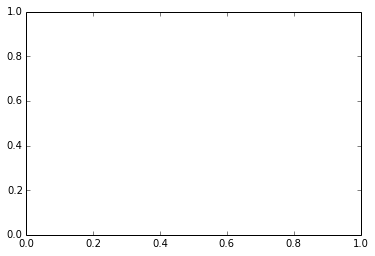

In [126]:
theta = np.pi*(35./180.)
v_wind = [0.0, 10.0, 0]
ys = run_simulation(theta, 0.01,'3d',v_wind)
ys = np.array(ys)

x = ys[:,0]
y = ys[:,2]
z = ys[:,4]
print(x.shape, y.shape, z.shape)
